# Imports



In [18]:
import dill
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
project_root = Path.cwd().parent
sys.path.append(str(project_root))

import src.unimib_snowit_project.utils as u

# Setup


In [19]:
# Constants
DATA_PKL_DIR = 'data_loaded'
USERS_PKL_FILENAME = 'users.pkl'
PROFILES_PKL_FILENAME = 'profiles.pkl'
CARDS_PKL_FILENAME = 'cards.pkl'
ORDERS_PKL_FILENAME = 'orders.pkl'
ORDER_DETAILS_PKL_FILENAME = 'order_details.pkl'

# File paths
root_dir_path = u.get_root_dir()
data_pkl_dir_path = root_dir_path.joinpath(DATA_PKL_DIR)

orders_pkl_path = data_pkl_dir_path.joinpath(ORDERS_PKL_FILENAME)
order_details_pkl_path = data_pkl_dir_path.joinpath(ORDER_DETAILS_PKL_FILENAME)

# Load data
with orders_pkl_path.open('rb') as f:
    orders_df = dill.load(f)

with order_details_pkl_path.open('rb') as f:
    order_details_df = dill.load(f)

# Join and filter successful purchases
df = orders_df.merge(order_details_df, on='order.uid')
df = df[df['item.status'].isin(['ok', 'fulfilled'])]

# Define reference date
df['createdAt'] = pd.to_datetime(df['createdAt'])
reference_date = df['createdAt'].max()


# Compute RFM metrics


In [20]:
rfm = df.groupby('user.uid').agg({
    'createdAt': lambda x: (reference_date - x.max()).days,  # Recency
    'order.uid': 'nunique',                                  # Frequency
    'item.amount': 'sum'                                     # Monetary
}).reset_index()

rfm.columns = ['user.uid', 'Recency', 'Frequency', 'Monetary']

## Define inactive customers



In [21]:
# Sort and calculate inter-purchase times
orders_df = orders_df.sort_values(['user.uid', 'createdAtTime'])

# Create a new column with previous purchase datetime
orders_df['prev_purchase_time'] = orders_df.groupby('user.uid')['createdAtTime'].shift(1)

# Calculate difference in days between purchases
orders_df['days_since_last_purchase'] = (
    orders_df['createdAtTime'] - orders_df['prev_purchase_time']
).dt.days

# Drop the first purchase per user (NaN intervals)
intervals = orders_df['days_since_last_purchase'].dropna()

# Remove weird intervals (same-day, negative, or too large)
intervals = intervals[intervals > 0]  # remove 0 or negative
intervals = intervals[intervals < 365]  # remove outliers beyond 1 year

### Plot ECDF


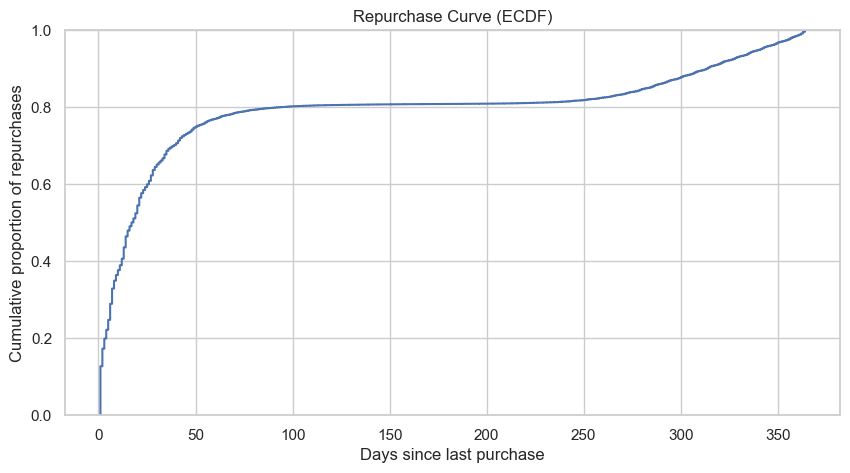

In [22]:
plt.figure(figsize=(10, 5))
sns.ecdfplot(intervals, stat='proportion')
plt.xlabel('Days since last purchase')
plt.ylabel('Cumulative proportion of repurchases')
plt.title('Repurchase Curve (ECDF)')
plt.grid(True)
plt.show()

### Calculate thresholds


80% of customers repurchase within 94 days
90% of customers repurchase within 314 days
Suggested inactive threshold: 94 days


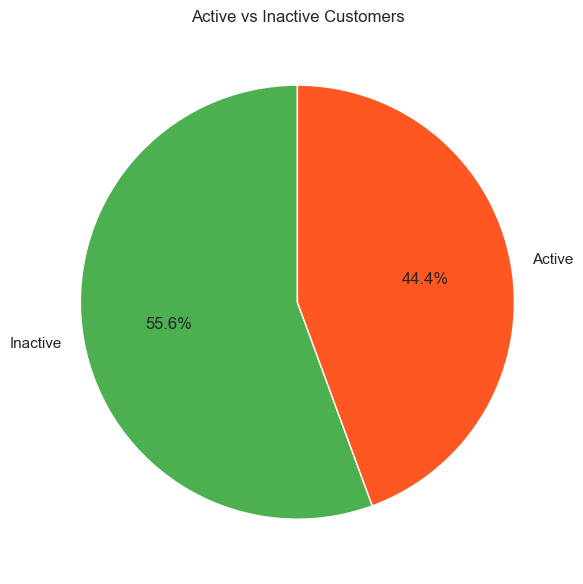

In [23]:
threshold_80 = intervals.quantile(0.80)
threshold_90 = intervals.quantile(0.90)

print(f"80% of customers repurchase within {int(threshold_80)} days")
print(f"90% of customers repurchase within {int(threshold_90)} days")

# Define inactive threshold suggestion
inactive_threshold = int(threshold_80)
print(f"Suggested inactive threshold: {inactive_threshold} days")

rfm['Status'] = rfm['Recency'].apply(lambda x: 'Inactive' if x > inactive_threshold else 'Active')

status_counts = rfm['Status'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    status_counts, 
    labels=status_counts.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['#4CAF50', '#FF5722']
)
plt.title('Active vs Inactive Customers')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

## Bin RFM components (Active only)


In [24]:
active_rfm = rfm[rfm['Status'] == 'Active'].copy()

# Recency
active_rfm['R_score'] = pd.qcut(active_rfm['Recency'], q=3, labels=[3, 2, 1], duplicates='drop').astype(int)


# Frequency
try:
    freq_qcut, freq_bins = pd.qcut(active_rfm['Frequency'], q=3, retbins=True, duplicates='drop')
    num_bins = len(freq_bins) - 1  # Number of actual bins
    active_rfm['F_score'] = pd.qcut(
        active_rfm['Frequency'], 
        q=num_bins, 
        labels=list(range(1, num_bins + 1)), 
        duplicates='drop'
    ).astype(int)
except ValueError as e:
    print("Could not compute F_score due to:", e)

# Monetary
active_rfm['M_score'] = pd.qcut(active_rfm['Monetary'], q=3, labels=[1, 2, 3], duplicates='drop').astype(int)

## RF Matrix


In [25]:
def rf_class(row):
    if row['R_score'] == 3 and row['F_score'] == 3:
        return 'Top'
    elif row['R_score'] >= 2 and row['F_score'] >= 2:
        return 'Engaged'
    elif row['R_score'] == 1:
        return 'Leaving'
    elif row['F_score'] == 1:
        return 'One-timer'
    else:
        return 'Leaving Top'

active_rfm['RF_class'] = active_rfm.apply(rf_class, axis=1)

# RFM Matrix. Segment assignment

In [26]:
def rfm_segment(row):
    if row['RF_class'] == 'Top' and row['M_score'] == 3:
        return 'Diamond'
    elif row['RF_class'] in ['Top', 'Engaged'] and row['M_score'] == 2:
        return 'Gold'
    elif row['RF_class'] in ['Engaged', 'Leaving Top'] and row['M_score'] == 2:
        return 'Silver'
    elif row['M_score'] == 1:
        return 'Bronze'
    elif row['RF_class'] == 'One-timer':
        return 'Tin'
    else:
        return 'Copper'

active_rfm['RFM_segment'] = active_rfm.apply(rfm_segment, axis=1)

## Analyze segments

/var/folders/yn/2fsl3m3j6t1gbkfscznw62s80000gn/T/ipykernel_9217/274379033.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


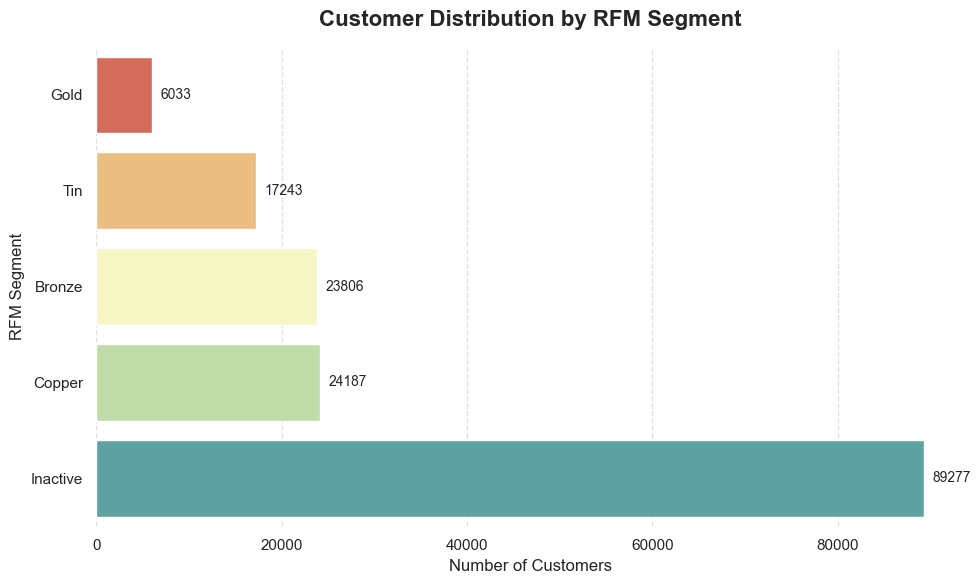

In [27]:
# Add inactive customers back
inactive_users = rfm[rfm['Status'] == 'Inactive'].copy()
inactive_users['RFM_segment'] = 'Inactive'

final_rfm = pd.concat([
    active_rfm[['user.uid', 'RFM_segment']],
    inactive_users[['user.uid', 'RFM_segment']]
])

segment_counts = final_rfm['RFM_segment'].value_counts().sort_values()

# Set up the plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(
    x=segment_counts.values, 
    y=segment_counts.index, 
    palette='Spectral'
)

# Add value labels on bars
for i, value in enumerate(segment_counts.values):
    ax.text(value + max(segment_counts.values)*0.01, i, str(value), va='center', fontsize=10)

# Title and labels
plt.title("Customer Distribution by RFM Segment", fontsize=16, weight='bold', pad=15)
plt.xlabel("Number of Customers", fontsize=12)
plt.ylabel("RFM Segment", fontsize=12)

# Remove spines and tidy layout
sns.despine(left=True, bottom=True)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()